***

# SVD
- 사용자, 아이템의 편향과 잠재요인의 교호작용을 추정하여 평점을 예측하는 행렬분해기법
- 기존의 SVD 행렬 분해 기법에 bias term이 추가된 개념

### - reference: [Recommender Systems Handbook, p151-152](https://link.springer.com/book/10.1007/978-0-387-85820-3)

### - Prediction:
평점 $r_{ui}$에 대해서 아래와 같이 잠재 요인 행렬 P, Q와 bias term으로 분해하는 것을 목표로 함

<center>$ \hat{r_{ui}} = \mu + b_i + b_u + q_i^Tp_u $</center>

|expression|mean|
|:---:|:---:|
|$ r_{ui}$|사용자 $u$의 아이템 $i$에 대한 평점|
|$\mu$|전체 평점의 평균|
|$b_i$|사용자 $u$의 편향|
|$b_u$| 아이템 $i$의 편향|
|$q_i^Tp_u$|사용자 $u$와 아이템 $i$의 교호작용|
|$ p_u$:|사용자의 잠재요인 행렬 $P_{n*k}$의 $u$번째 열벡터|
|$q_i$|아이템의 잠재요인 행렬 $Q_{m*k}$의 $i$번째 열벡터|
|$n$|사용자 수|
|$m$|아이템 수|
|$k$|잠재 요인 갯수|

### - Optimization:
관측된 평점에 대하여, 아래와 같은 목적함수를 최소화하는 minima를 찾음으로써 파라미터를 추정함

<center>$\min_{b_*, p_*, q_*}\sum_{(u,i)\in\kappa}(r_{ui}-\mu-b_i-b_u-q_i^Tp_u)^2 + \lambda(b_i^2+b_u^2+||q_i||^2+||p_u||^2)$</center>

|expression|mean|
|:---:|:---:|
|$\lambda$|규제항 상수|

### - Evaluation
|split|measure|
|:---:|:---:|
|holdout|RMSE|   

***

## 0) Import library

In [1]:
import os
import sys
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))

from Generator.PointwiseGenerator import PointwiseGenerator
from Models.SVD import SVD

import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

***

## 1) Data processing

### load data

In [2]:
ratings = pd.read_csv('../data/movie_lens/ratings.csv',
                      names=['user_id', 'item_id', 'rating', '_'],
                      skiprows=1).drop(columns=['_'])
ratings

,user_id,item_id,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


### convert id to index

In [3]:
user_ids = ratings['user_id'].unique().tolist()
item_ids = ratings['item_id'].unique().tolist()

num_user = len(user_ids)
num_item = len(item_ids)

id_to_index_user = {user_ids[i] :i for i in range(num_user)}
id_to_index_item = {item_ids[i] :i for i in range(num_item)}

ratings['user_id'] = ratings['user_id'].apply(lambda x: id_to_index_user[x])
ratings['item_id'] = ratings['item_id'].apply(lambda x: id_to_index_item[x])

ratings

,user_id,item_id,rating
0,0,0,4.0
1,0,1,4.0
2,0,2,4.0
3,0,3,5.0
4,0,4,5.0
...,...,...,...
100831,609,3120,4.0
100832,609,2035,5.0
100833,609,3121,5.0
100834,609,1392,5.0


### split data

In [4]:
val_ratio = 0.1
test_ratio = 0.2
seed = 1234

train, others = train_test_split(ratings,
                                 test_size=val_ratio+test_ratio,
                                 shuffle=True,
                                 random_state=seed)

validation, test = train_test_split(others,
                                    test_size=test_ratio/(val_ratio+test_ratio),
                                    shuffle=True,
                                    random_state=seed)

print(f"# of observation(train/val/test): {len(train)}, {len(validation)}, {len(test)}")

# of observation(train/val/test): 70585, 10083, 20168


### set config & get dataset from generator

In [5]:
class DatasetConfig:
    num_negative = 0
    batch = 128

dataset_config = DatasetConfig()

In [6]:
dataset = PointwiseGenerator(train_data=train,
                             n_user=num_user,
                             n_item=num_item,
                             config=dataset_config)

### see example data for a batch

In [13]:
train_loader = DataLoader(dataset, batch_size=2)
data1, data2, data3, _ = next(iter(train_loader))

(1) [user id X batch_size]

In [16]:
data1

tensor([598, 523])

(2) [item id X batch_size]

In [15]:
data2

tensor([2947,  530])

(3) [ [rating] X batch_size]

In [14]:
data3

tensor([[2.5000],
        [5.0000]])

***

## 2) Modeling

### set config & get model

In [8]:
class OptimizerConfig:
    method = 'SGD'
    regulation = 1e-5
    learning_rate = 0.01
    learning_decay = 0.95

class ModelConfig:
    epochs = 30
    print_step = 5

class SVDConfig:
    evaluation = 'MSE'
    dim_latent = 16

optimizer_config = OptimizerConfig()
svd_config = SVDConfig()
model_config = ModelConfig()

In [9]:
inputs = {"mu":train['rating'].mean(),
          "n_user":num_user,
          "n_item":num_item}

model = SVD(inputs, model_config, optimizer_config, svd_config)

[BaseModel] method = SGD
[BaseModel] regulation = 1e-05
[BaseModel] learning_rate = 0.01
[BaseModel] learning_rate_decay = 0.95


### fit model & see loss and performance

In [10]:
train_loader = DataLoader(dataset, batch_size=dataset_config.batch)
model.fit(train_loader=train_loader, val_data=validation)


[SVD]============================================== Train ===============================================
[SVD]               (train: MSE)        (validation: MSE)   
          (epoch 5) 10.8635             23.5397             
         (epoch 10) 8.2115              21.2682             
         (epoch 15) 6.9219              20.1338             
         (epoch 20) 6.1755              19.4679             
         (epoch 25) 5.7015              19.0416             
         (epoch 30) 5.3825              18.7530             


***

## 3) Evaluation

### evaluate testset

In [11]:
model.test(train_loader=train_loader, test_data=test)


[SVD]============================================= Evaluate =============================================
[SVD] (test: MSE) = 18.8665


### see plot for loss and performance

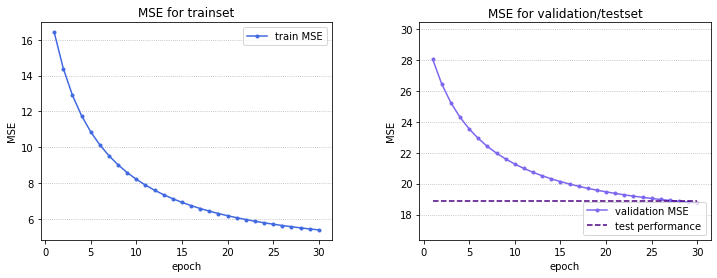

In [12]:
figure = model.draw_plot()
plt.show()